In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import Image, display
from statsmodels.regression.linear_model import OLS

# Trend

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class Trend:
    def __init__(self, df, y: str, x: str):
        self.df = df
        self.x = x
        self.y = y

    def _index_df(self):
        idf = pd.DataFrame(self.df[[self.x, self.y]])
        idf[self.x] = pd.to_datetime(idf[self.x], infer_datetime_format = True)
        idf = idf.set_index([self.x])
        self.idf = idf

    def trend(self):
        self._index_df()
        t = seasonal_decompose(self.idf, model = "multiplicative").trend
        return t

    def plot(self, show_plot = False):
        t = self.trend()
        vals = t.array.dropna().tolist()
        if not show_plot:
            return {
                "title": "Trend of " + self.idf.columns[0] + ":",
                "data": vals,
                "x": [str(i.date()) for i in self.idf.index.to_list()]
            }
        else:
            t.plot()

    def detrend(self):
        least_squares = OLS(self.df[self.y].values, list(range(self.df.shape[0])))
        result = least_squares.fit()
        fit = pd.Series(result.predict(list(range(df.shape[0]))), index = self.df.index)
        detrended = self.df[self.y].values - fit.values

        detrend_df = pd.DataFrame()
        detrend_df['Original'] = self.df[self.y]
        detrend_df['Detrend'] = pd.Series(detrended)
        detrend_df[self.x] = self.df[self.x]
        detrend_df = detrend_df.set_index([self.x])
        return detrend_df


    def plot_detrend(self, show_plot = False):
        d = self.detrend()
        if not show_plot:
            return {
                "title": "Original vs Detrend of " + self.idf.columns[0] + ":",
                "data": d['Original'].values.tolist(),
                "data_detrend": d['Detrend'].values.tolist(),
                "x": [str(i.date()) for i in self.idf.index.to_list()]
            }
        else:
            d.plot()




In [4]:
df = pd.read_csv('/content/drive/MyDrive/data/2/Electric_Production.csv')

In [5]:
y = 'IPG2211A2N'

In [6]:
x = 'DATE'

In [7]:
t = Trend(df, y, x)

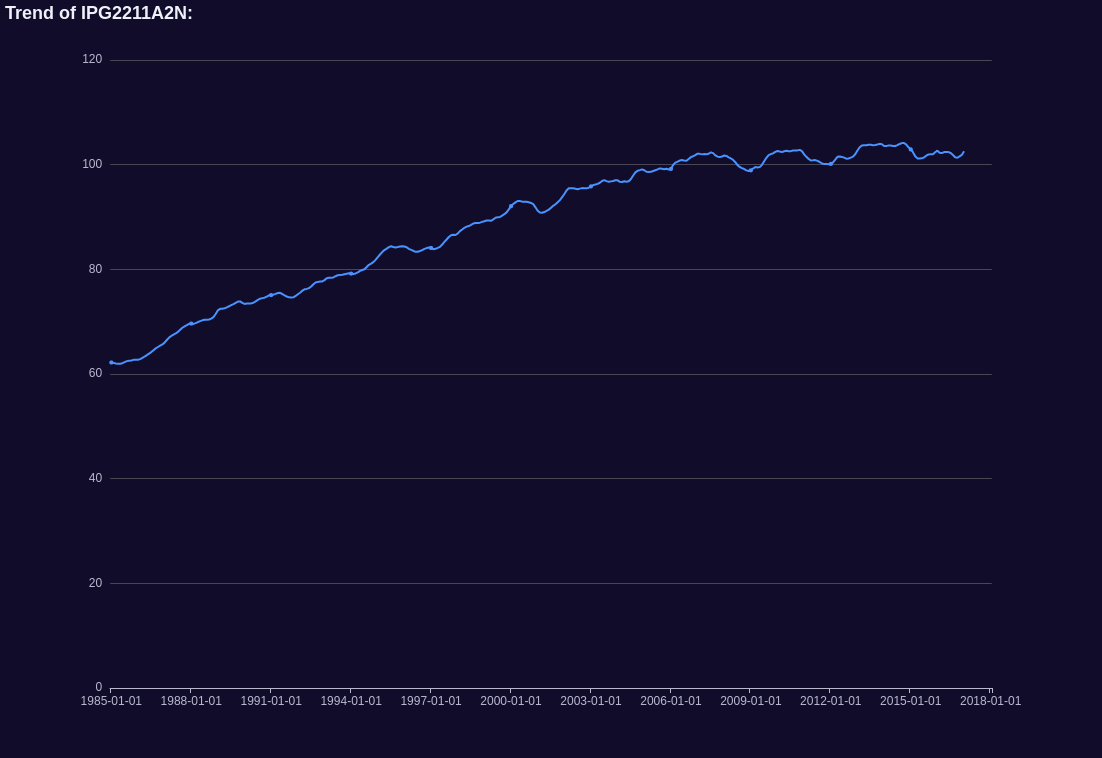

In [8]:
display(Image(filename = '/content/drive/MyDrive/echarts_pngs/trend.png'))

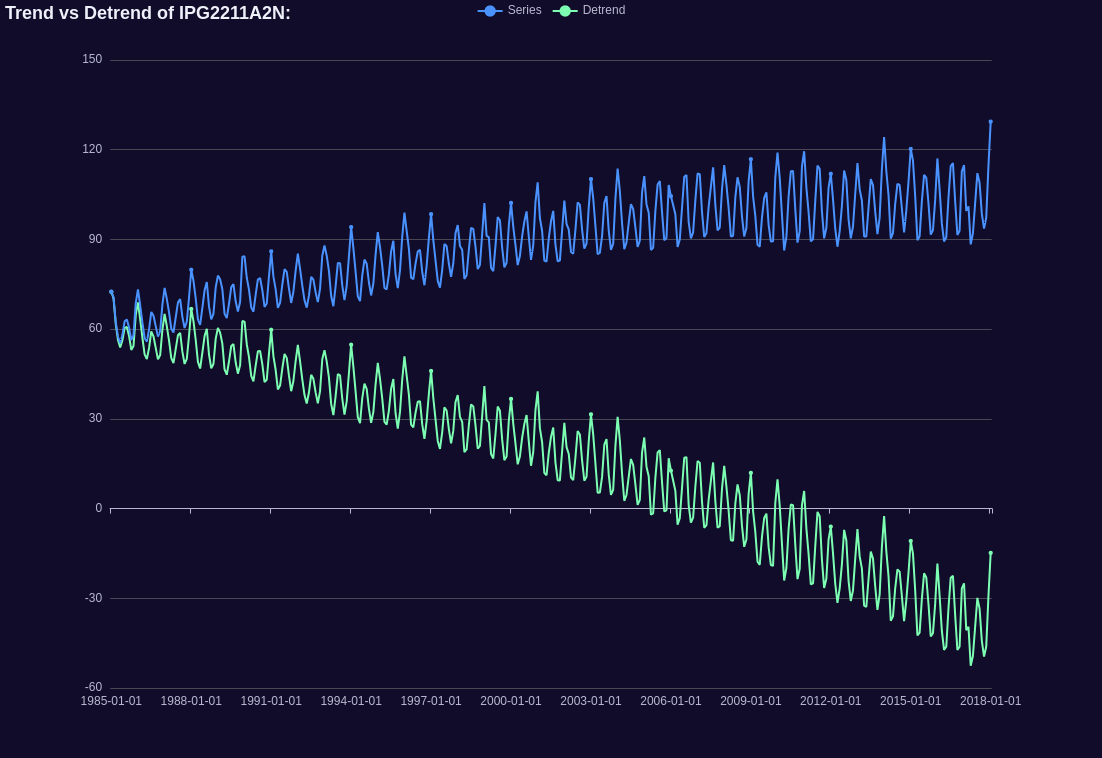

In [9]:
display(Image(filename='/content/drive/MyDrive/echarts_pngs/detrend.png'))

# Seasonality

In [10]:
class Seasonality:
    def __init__(self, df, y: str, x: str):
        self.df = df
        self.x = x
        self.y = y

    def _index_df(self):
        idf = pd.DataFrame(self.df[[self.x, self.y]])
        idf[self.x] = pd.to_datetime(idf[self.x], infer_datetime_format = True)
        idf = idf.set_index([self.x])
        self.idf = idf

    def seasonal(self):
        self._index_df()
        t = seasonal_decompose(self.idf, model = "multiplicative").seasonal
        return t

    def plot(self, show_plot = False):
        t = self.seasonal()
        vals = t.array.dropna().tolist()
        if not show_plot:
            return {
                "title": "Seasonality of " + self.idf.columns[0] + ":",
                "data": vals,
                "x": [str(i.date()) for i in self.idf.index.to_list()]
            }
        else:
            t.plot()

    def deseasonalize(self):
        de = self.df[self.y].values / self.seasonal()
        deseasonalize_df = pd.DataFrame()
        deseasonalize_df['Original'] = self.df[self.y]
        deseasonalize_df['Deseasonalized'] = pd.Series(de.values)
        deseasonalize_df[self.x] = self.df[self.x]
        deseasonalize_df = deseasonalize_df.set_index([self.x])
        return deseasonalize_df

    def plot_deseasonalize(self, show_plot = False):
        d = self.deseasonalize()
        if not show_plot:
            return {
                "title": "Original vs Deseasonalized of " + self.idf.columns[0] + ":",
                "data": d['Original'].values.tolist(),
                "data_des": d['Deseasonalized'].values.tolist(),
                "x": [str(i.date()) for i in self.idf.index.to_list()]
            }
        else:
            d.plot()


In [11]:
s = Seasonality(df,y, x )

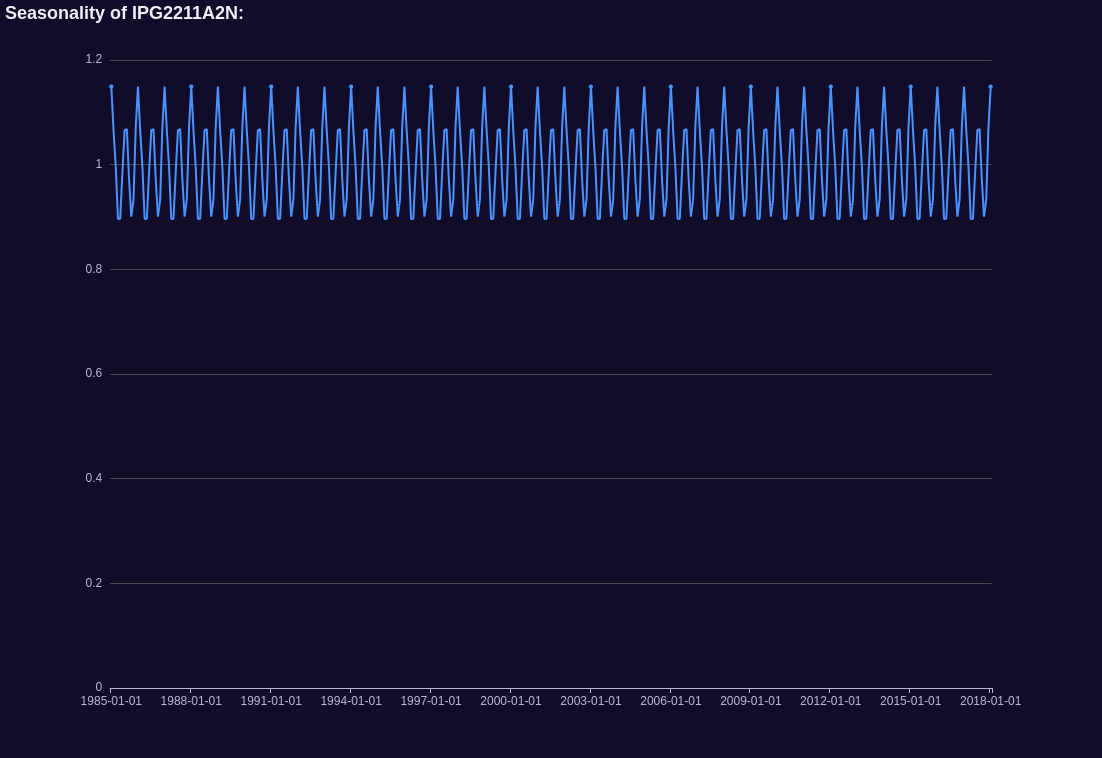

In [12]:
display(Image(filename = '/content/drive/MyDrive/echarts_pngs/seasonality.png'))

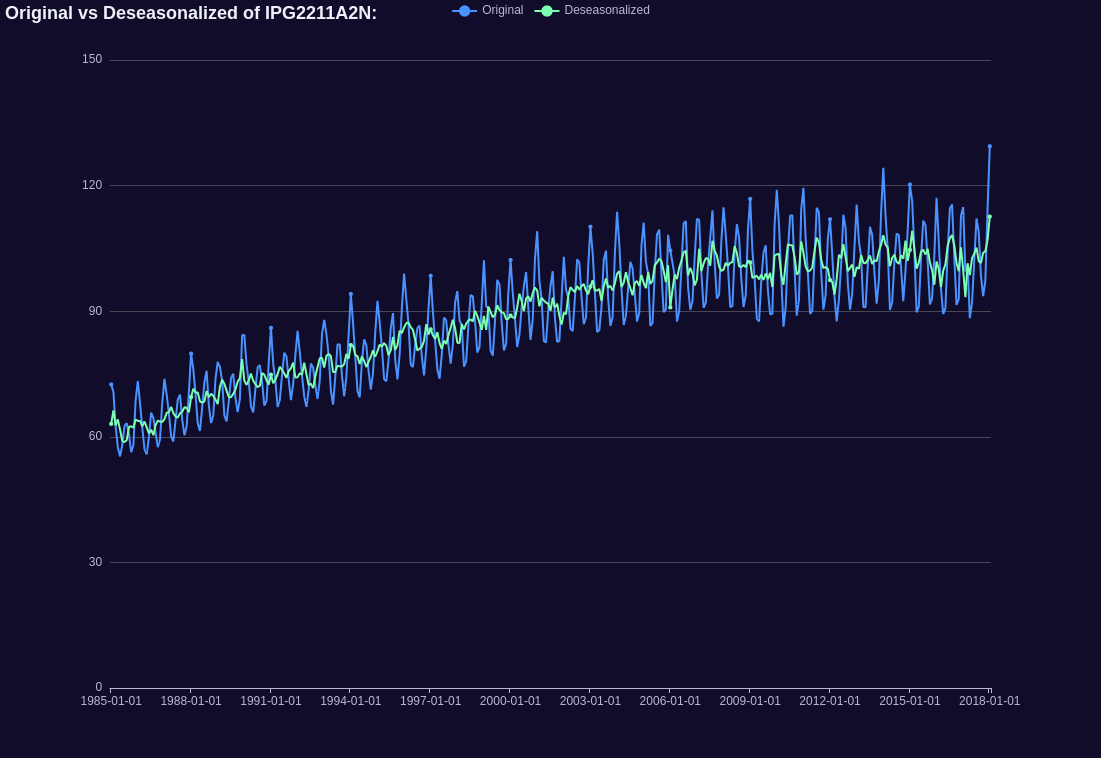

In [13]:
display(Image(filename = '/content/drive/MyDrive/echarts_pngs/deseasonalized.png'))

# Stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller, kpss, range_unit_root_test
import matplotlib.pyplot as plt

In [15]:
class Stationarity:
    def __init__(self, df, x, y):
        self.df = df
        self.x = x
        self.y = y

    def test_stationarity(self, test = 'adf', show_results = True):
        if test == 'adf':
            dftest = adfuller(self.df[self.y], autolag = 'AIC')
            print("1. ADF : ",dftest[0])
            print("2. P-Value : ", dftest[1])
            print("3. Num Of Lags : ", dftest[2])
            print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
            print("5. Critical Values :")
            for key, val in dftest[4].items():
              print("\t",key, ": ", val)
            if dftest[1] > 0.05:
                print("\n\nAs p-value is outside the confidence interval of 95%, series is non-stationary.")
            else:
                print("\n\nAs p-value is inside the confidence interval of 95%, series is stationary.")
        elif test == 'kpss':
            dftest = kpss(self.df[self.y], regression = 'ct')
            print("1. KPSS : ",dftest[0])
            print("2. P-Value : ", dftest[1])
            print("3. Num Of Lags : ", dftest[2])
            # print("4. Num Of Observations Used For KPSS Regression and Critical Values Calculation :", dftest[3])
            print("4. Critical Values :")
            for key, val in dftest[3].items():
                print("\t",key, ": ", val)
            if dftest[1] > 0.05:
                print("\n\nAs p-value is outside the confidence interval of 95%, series is non-stationary.")
            else:
                print("\n\nAs p-value is inside the confidence interval of 95%, series is stationary.")
        elif test == 'rur':
            dftest = range_unit_root_test(self.df[self.y])
            print("1. RUR Stat : ",dftest[0])
            print("2. P-Value : ", dftest[1])
            # print("3. Num Of Lags : ", dftest[2])
            # print("4. Num Of Observations Used For KPSS Regression and Critical Values Calculation :", dftest[3])
            print("3. Critical Values :")
            for key, val in dftest[2].items():
                print("\t",key, ": ", val)
            if dftest[1] > 0.05:
                    print("\n\nAs p-value is outside the confidence interval of 95%, series is non-stationary.")
            else:
                    print("\n\nAs p-value is inside the confidence interval of 95%, series is stationary.")
        else:
            print("Invlaid Test.")


    def make_stationary(self, method = None, rolling = True, window = 12, test = True ):
        timeseries = self.df[self.y]
        if not method: # only using rolling mean
            rolling_mean = timeseries.rolling(window = window).mean()
            rolling_mean_diff = rolling_mean - rolling_mean.shift()
            transformed = rolling_mean_diff
        else:
            if method == 'log':
                log = pd.Series(np.log(timeseries.values))
                if not rolling: # only log transform
                    log_diff = log - log.shift()
                    transformed = log_diff
                if rolling: # log transform and rolling
                    rolling_log = log.rolling(window = window).mean()
                    diff = rolling_log - rolling_log.shift()
                    transformed = diff
            elif method == 'power':
                power = pd.Series(np.sqrt(timeseries.values))
                if not rolling: # only power transform
                    power_diff = power - power.shift()
                    transformed = power_diff
                if rolling: # power transform and rolling
                    rolling_power = power.rolling(window = window).mean()
                    diff = rolling_power - rolling_power.shift()
                    transformed = diff
            else:
                print("Invalid Method")
                return

        if test:
            p_val = adfuller(transformed.dropna())[1]
            if p_val < 0.05:
                print("p-value: ", p_val, '\nAs p-value is lesser than 0.05, transformed series is stationary.')
            else:
                print("p-value: ", p_val, '\nAs p-value is greater than 0.05, transformed series is non-stationary.')
        self.transformed = transformed
        return transformed.dropna()

    def get_transform_plot_params(self):
        return {
            'title': 'Transformed series',
            'data': self.transformed.dropna().values.tolist(),
            'x': self.df[self.x].values.tolist()
        }


In [16]:
s = Stationarity(df, x, y)

In [17]:
s.test_stationarity(test = 'adf')


1. ADF :  -2.256990350047235
2. P-Value :  0.1862146911658712
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 381
5. Critical Values :
	 1% :  -3.4476305904172904
	 5% :  -2.869155980820355
	 10% :  -2.570827146203181


As p-value is outside the confidence interval of 95%, series is non-stationary.


In [18]:
s.test_stationarity(test = 'kpss')

1. KPSS :  0.5051030832418743
2. P-Value :  0.01
3. Num Of Lags :  16
4. Critical Values :
	 10% :  0.119
	 5% :  0.146
	 2.5% :  0.176
	 1% :  0.216


As p-value is inside the confidence interval of 95%, series is stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [19]:
s.test_stationarity(test = 'rur')


1. RUR Stat :  1.3049025943940886
2. P-Value :  0.1
3. Critical Values :
	 10% :  1.3893072
	 5% :  1.251836
	 2.5% :  1.1434528
	 1% :  1.0283056000000002


As p-value is outside the confidence interval of 95%, series is non-stationary.


In [20]:
transformed = s.make_stationary(method = 'log', rolling = False)

p-value:  2.99516149811584e-09 
As p-value is lesser than 0.05, transformed series is stationary.


In [21]:
# s.get_transform_plot_params()

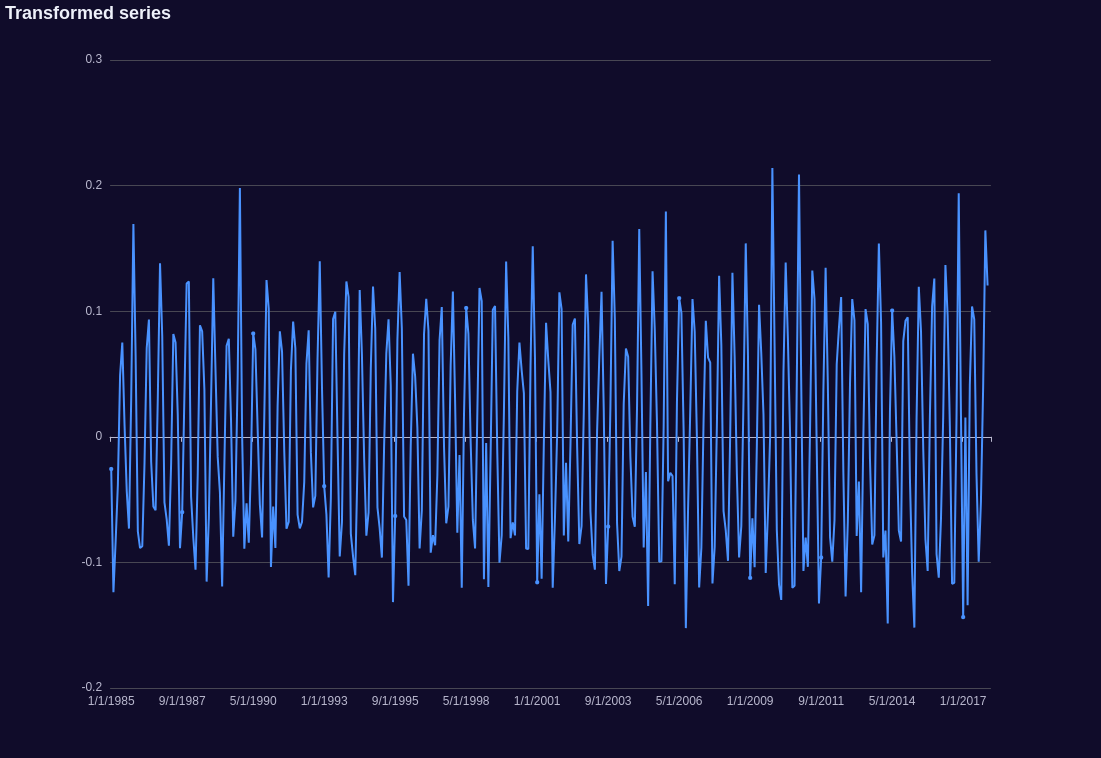

In [22]:
display(Image(filename = '/content/drive/MyDrive/echarts_pngs/stationary_transform.png'))

In [23]:
transformed

1     -0.025609
2     -0.123680
3     -0.083082
4     -0.038242
5      0.048954
         ...   
392   -0.099489
393   -0.052051
394    0.038991
395    0.164337
396    0.120441
Length: 396, dtype: float64

# Autocorrelation/Partial Autocorrelation

In [24]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

In [25]:
class Autocorrelation:
    def __init__(self):
        self.acf = None

    def autocorrelation(self, timeseries, differencing = 1,  n_lags = 20):
        diff = timeseries - timeseries.shift()
        for i in range(differencing-1):
            diff = diff - diff.shift()
        self.diff = diff
        lag_acf = acf(diff.dropna(), nlags = n_lags)
        self.acf = lag_acf

        return {
            'title': 'Autocorrelation plot: differencing = ' + str(differencing),
            'acf_line': lag_acf.tolist(),
            'lower': [-1.96/np.sqrt(len(diff))]*len(lag_acf),
            'upper': [1.96/np.sqrt(len(diff))]*len(lag_acf),
            'zero': [0] * len(lag_acf),
            'x':list(range(len(lag_acf)))
        }

    def durbin_watson_test(self, timeseries, summary = False):
      x = timeseries.index
      y = timeseries.values
      x = sm.add_constant(x)
      reg = sm.OLS(y, x).fit()
      dwtest= durbin_watson(resids = np.array(reg.resid))
      if summary:
        zero, two, four = abs(dwtest), abs(dwtest - 2), abs(dwtest - 4)
        if min(zero, two, four) == zero:
          print("As value of statistic is close to 0, series is positively autocorrelated.")
        elif min(zero, two, four) == two:
          print("As value of statistic is close to 2, series is not autocorrelated.")
        else:
          print("As value of statistic is close to 4, series is negatively autocorrelated.")
      return dwtest

    def estimate_q(self):
        if self.acf is not None:
            u_conf = 1.96/np.sqrt(len(self.diff))
            for i in range(len(self.acf)):
                if self.acf[i] > u_conf:
                    return i, i+1
        else:
            print('Run Autocorrelation.autocorrelation() first')



In [26]:
a = Autocorrelation()

In [27]:
r = a.autocorrelation(df[y], 2)


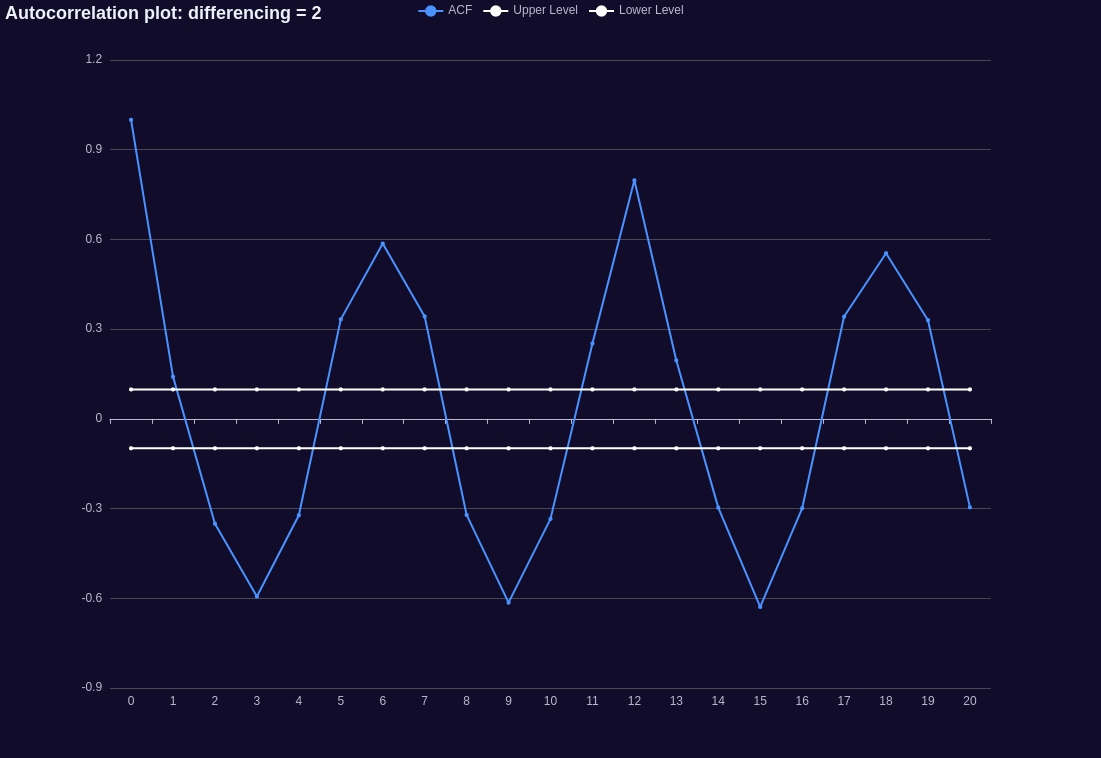

In [28]:
display(Image(filename = '/content/drive/MyDrive/echarts_pngs/acf.png'))

In [29]:
a.estimate_q()

(0, 1)

In [30]:
a.durbin_watson_test(df[y], summary = True)

As value of statistic is close to 0, series is positively autocorrelated.


0.831475657889986

In [31]:
class PartialAutocorrelation:
    def __init__(self):
        self.pacf = None

    def partial_autocorrelation(self, timeseries, differencing = 1,  n_lags = 20):
        diff = timeseries - timeseries.shift()
        for i in range(differencing-1):
            diff = diff - diff.shift()
        self.diff = diff
        lag_pacf = pacf(diff.dropna(), nlags = n_lags)
        self.pacf = lag_pacf

        return {
            'title': 'Partial autocorrelation plot: differencing = ' + str(differencing),
            'pacf_line': lag_pacf.tolist(),
            'lower': [-1.96/np.sqrt(len(diff))]*len(lag_pacf),
            'upper': [1.96/np.sqrt(len(diff))]*len(lag_pacf),
            'zero': [0] * len(lag_pacf),
            'x':list(range(len(lag_pacf)))
        }

    def estimate_p(self):
        if self.pacf is not None:
            u_conf = 1.96/np.sqrt(len(self.diff))
            for i in range(len(self.pacf)):
                if self.pacf[i] > u_conf:
                    return i,i+1
        else:
            print('Run PartialAutocorrelation.partial_autocorrelation() first.')



In [32]:
p = PartialAutocorrelation()

In [33]:
r = p.partial_autocorrelation(df[y], 2)


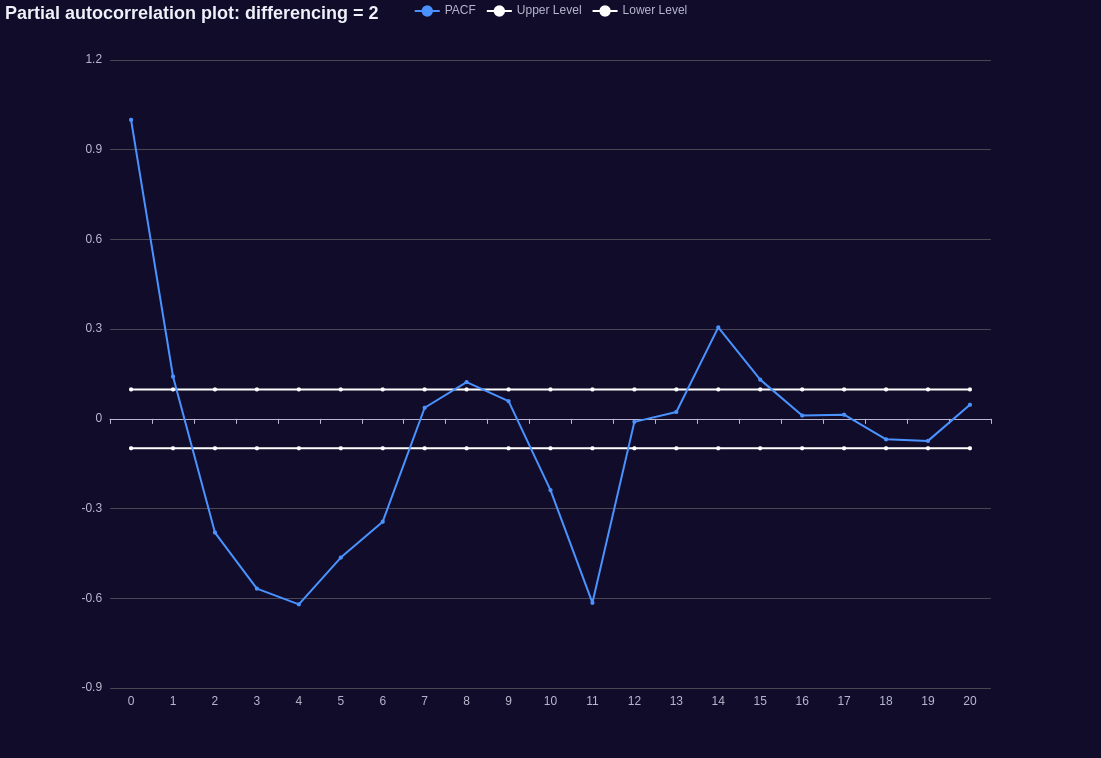

In [34]:
display(Image(filename='/content/drive/MyDrive/echarts_pngs/pacf.png'))

In [35]:
p.estimate_p()

(0, 1)

# Cross Correlation

In [36]:
from statsmodels.tsa.stattools import ccf

In [37]:
class CrossCorrelation:
    def __init__(self, series1, series2, x):
        self.series1 = series1
        self.series2 = series2
        self.time = x

    def cross_correlation(self, lag):
        corr = ccf(self.series1.values.tolist(), self.series2.values.tolist(), adjusted = False)
        self.ccf = corr
        return corr[lag]

    def plot(self):
        return {
            'legend': [self.series1.name,self.series2.name],
            1: self.series1.values.tolist(),
            2: self.series2.values.tolist(),
            'x': self.time.values.tolist()
        }

    def summary(self):
#         pd.Series(self.ccf).plot()
        print("Max positive correlation is", max(self.ccf) ,"at lag = ", np.argmax(self.ccf), "\nMax negative correlation is",min(self.ccf) ," at lag = ", np.argmin(self.ccf))


In [38]:
df1 = pd.read_csv('/content/drive/MyDrive/data/3/DailyDelhiClimateTrain.csv')
df1.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [39]:
c = CrossCorrelation(df1['meantemp'], df1['wind_speed'], df1['date'])

In [40]:
c.cross_correlation(2)

0.286651637297374

In [41]:
c.ccf

array([0.30646771, 0.28575463, 0.28665164, ..., 0.00308486, 0.00265996,
       0.00215235])

In [42]:
c.summary()

Max positive correlation is 0.3604581818502781 at lag =  43 
Max negative correlation is -0.3137025644131462  at lag =  216


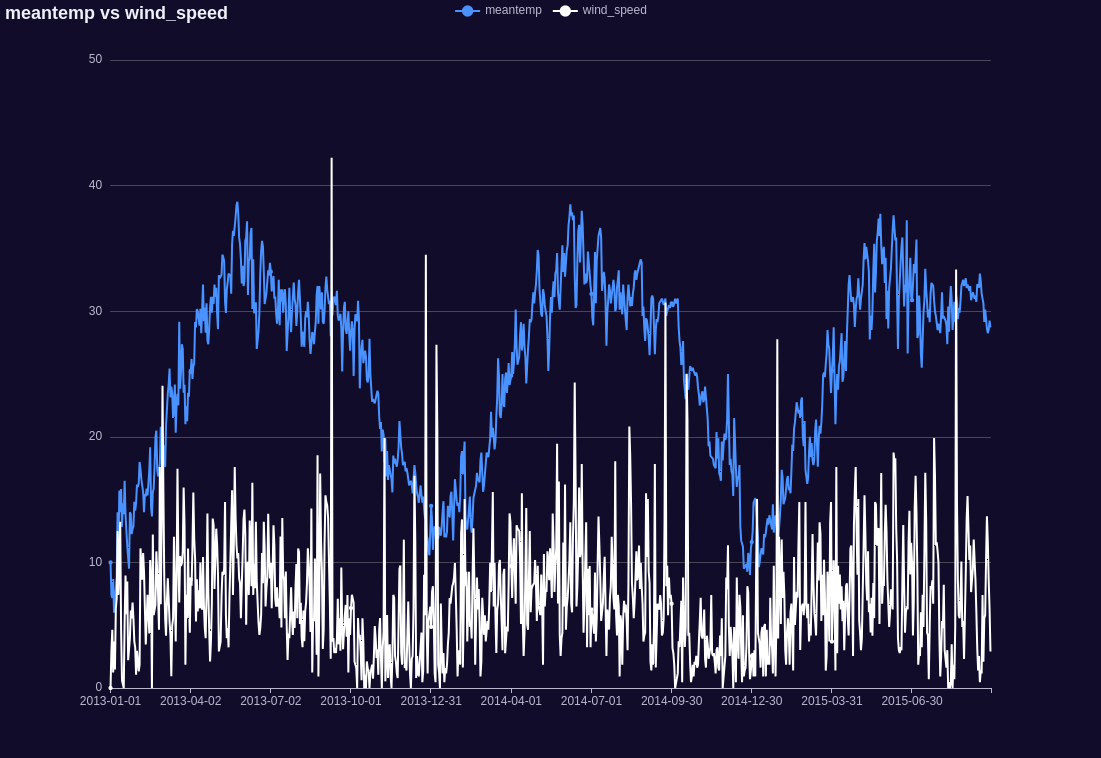

In [43]:
display(Image(filename='/content/drive/MyDrive/echarts_pngs/crosscorrelation.png'))

# Granger Causality Test

In [44]:
from statsmodels.tsa.stattools import grangercausalitytests

In [45]:
def granger_causality_matrix(data, variables, maxlag = 12, test='ssr_chi2test', verbose=False, summary = False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    if summary:
      array = df.values
      for i in range(len(array)):
        for j in range(len(array[i])):
          if array[i][j] < 0.05:
            print(df.columns[j][:-2], " \"granger causes\" ", df.index[i][:-2], " with p-value of ", array[i][j], ".\n", sep = "")
    return df

In [46]:
granger_causality_matrix(df1, ['meantemp', 'meanpressure', 'wind_speed', 'humidity'], summary = True)

wind_speed "granger causes" meantemp with p-value of 0.0005.

humidity "granger causes" meantemp with p-value of 0.0038.

meantemp "granger causes" meanpressure with p-value of 0.0063.

wind_speed "granger causes" meanpressure with p-value of 0.0425.

meantemp "granger causes" wind_speed with p-value of 0.0.

humidity "granger causes" wind_speed with p-value of 0.0.

meantemp "granger causes" humidity with p-value of 0.0.



,meantemp_x,meanpressure_x,wind_speed_x,humidity_x
meantemp_y,1.0000,0.2201,0.0005,0.0038
meanpressure_y,0.0063,1.0000,0.0425,0.4364
wind_speed_y,0.0000,0.5229,1.0000,0.0000
humidity_y,0.0000,0.1505,0.1332,1.0000


# Differencing

In [47]:
df = pd.read_csv('/content/drive/MyDrive/data/2/monthly-beer-production-in-austr.csv')
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [48]:
class Differencing:
  def __init__(self, df, y, x, order = 1):
    self.df = df
    self.y = y
    self.x = x
    self.order = order
    self.diff = self._get_diff().dropna()

  def _diff(self, order):
    return self.df[self.y].diff(order)

  def _get_diff(self):
    return self.df[self.y].diff(self.order)

  def plot_diff(self):
    return {
        "data" : self.diff.values.tolist(),
        "x": self.df[self.x].values.tolist()
    }

  def adf_test(self):
     p_val = adfuller(self.diff)[1]
     if p_val < 0.05:
         print("p-value: ", p_val, '\nAs p-value is lesser than 0.05, transformed series is stationary.')
     else:
        print("p-value: ", p_val, '\nAs p-value is greater than 0.05, transformed series is non-stationary.')

  def estimate_d(self, max_d = 3):
    for i in range(1, max_d+1):
      p = adfuller(self._diff(i).dropna())[1]
      if p < 0.05:
        return i
    return


In [49]:
d = Differencing(df, 'Monthly beer production', 'Month')

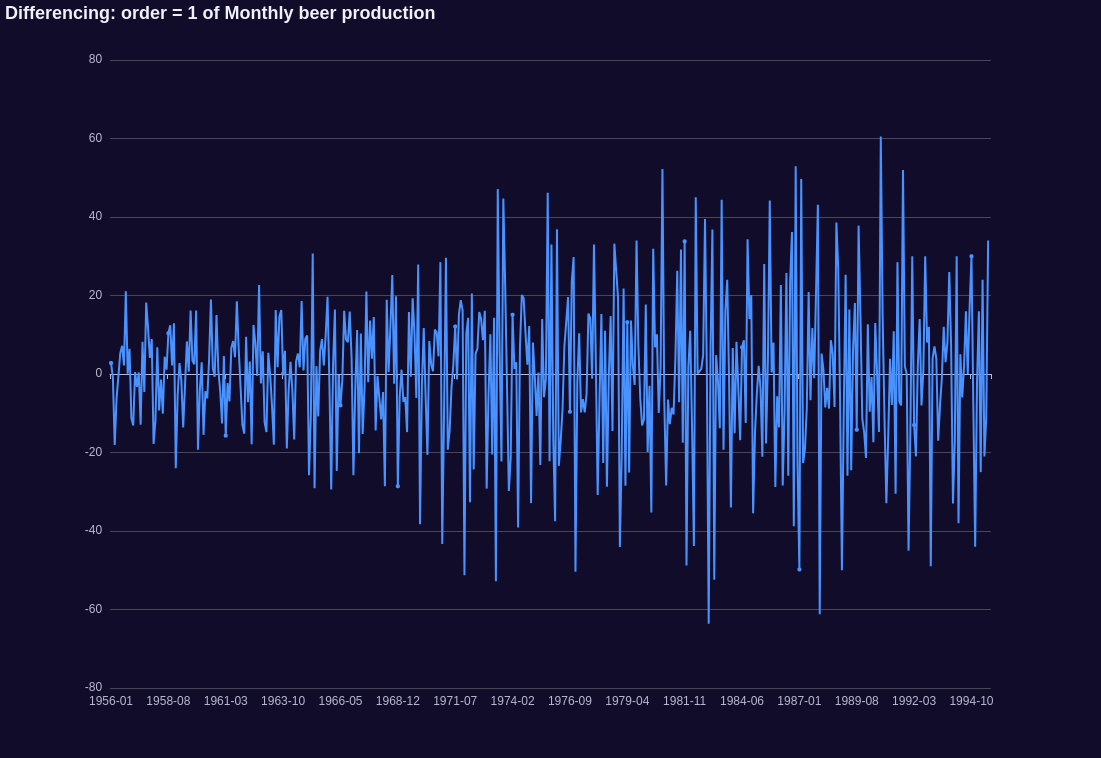

In [50]:
display(Image(filename='/content/drive/MyDrive/echarts_pngs/differencing.png'))


In [51]:
d.adf_test()

p-value:  2.4234117859977578e-05 
As p-value is lesser than 0.05, transformed series is stationary.


In [52]:
d.estimate_d(max_d = 6)

1

# Autocovariance

In [53]:
from statsmodels.tsa.stattools import acovf

In [54]:
class Autocovariance:
  def __init__(self):
    return

  def autocovariance(self, timeseries):
    return acovf(timeseries)

  def plot(self, timeseries, x):
    return {
        'title': 'Autocovariance of ' + timeseries.name + ':',
        'y': self.autocovariance(timeseries).tolist(),
        'x': x.values.tolist()
    }

In [55]:
a = Autocovariance()
a.autocovariance(df['Monthly beer production'])

array([ 1.13591015e+03,  9.41332716e+02,  8.35753907e+02,  7.74422941e+02,
        6.76037492e+02,  6.36620804e+02,  5.76043385e+02,  6.04081575e+02,
        6.81016146e+02,  7.49987894e+02,  8.02894444e+02,  9.31059981e+02,
        1.01818161e+03,  8.91354796e+02,  8.16168601e+02,  7.15954290e+02,
        6.28911907e+02,  6.02656060e+02,  5.22337154e+02,  5.71402851e+02,
        6.37545717e+02,  6.81597120e+02,  7.57954463e+02,  8.75590023e+02,
        9.45480428e+02,  8.48549417e+02,  7.66775906e+02,  6.57196606e+02,
        5.91165218e+02,  5.48418216e+02,  4.54622485e+02,  5.28031401e+02,
        5.88988518e+02,  6.16439071e+02,  7.19970691e+02,  8.08770981e+02,
        8.75285470e+02,  8.07062955e+02,  6.84836926e+02,  5.92094852e+02,
        5.48145417e+02,  4.76812464e+02,  3.96939077e+02,  4.84924220e+02,
        5.06885544e+02,  5.59066548e+02,  6.68982707e+02,  7.20860941e+02,
        8.10459019e+02,  7.33486597e+02,  5.99514547e+02,  5.40353353e+02,
        4.80382097e+02,  

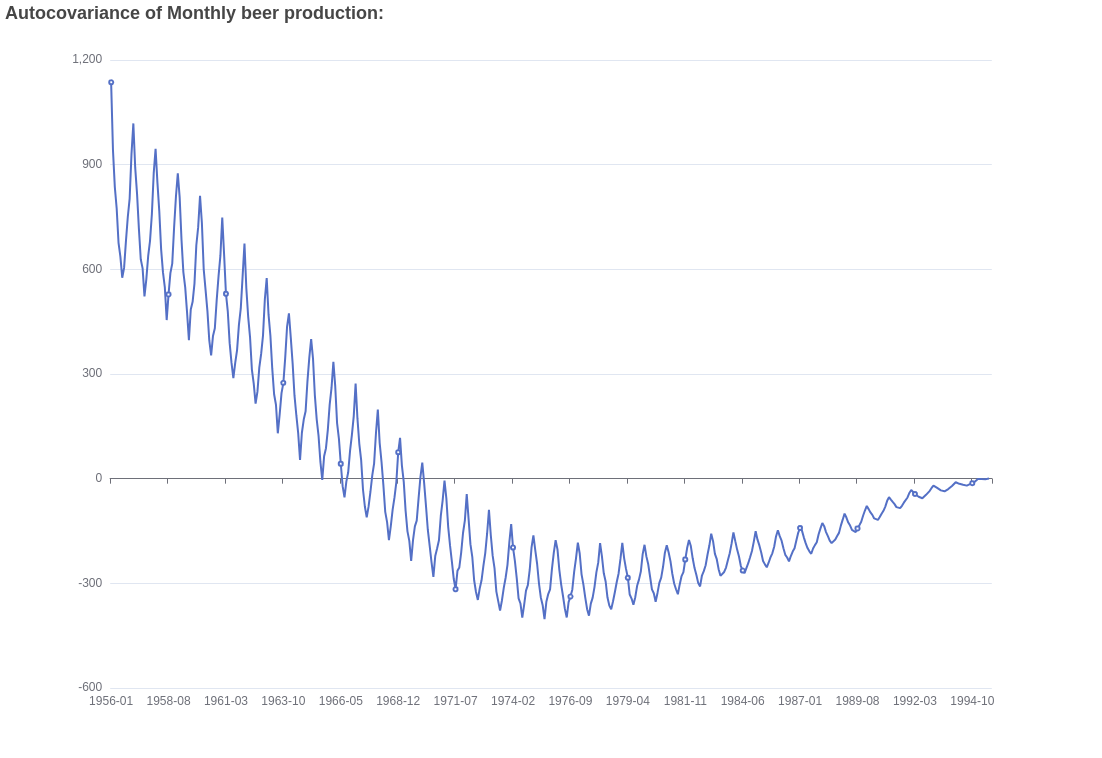

In [56]:
display(Image(filename='/content/drive/MyDrive/echarts_pngs/autocovariance.png'))

# Cross Covariance

In [57]:
from statsmodels.tsa.stattools import ccovf

In [58]:
class CrossCovariance:
  def __init__(self):
    return

  def cross_covariance(self, timeseries1, timeseries2):
    return ccovf(timeseries1, timeseries2)

  def plot(self, timeseries1, timeseries2, x):
    return {
        'title': 'Cross covariance of ' + timeseries1.name + ' with ' + timeseries2.name + ':',
        'y': self.cross_covariance(timeseries1, timeseries2).tolist(),
        'x': x.values.tolist()
    }

In [59]:
df = pd.read_csv('/content/drive/MyDrive/data/3/DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [60]:
c = CrossCovariance()
c.cross_covariance(df['meantemp'], df['wind_speed'])

array([ 10.26550202,   9.57824411,   9.61489204, ...,  50.35661917,
        65.13091301, 105.40376615])

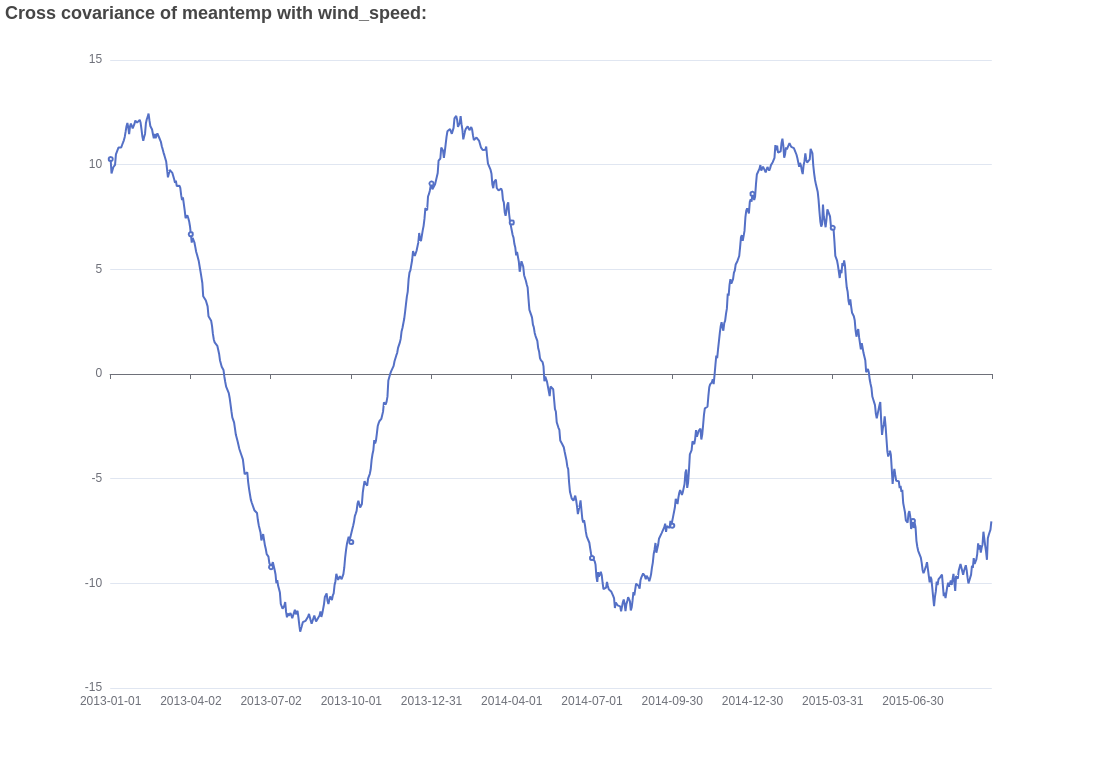

In [61]:
display(Image(filename = '/content/crosscovariance.png'))